# Brain Tumor Detection with Xception

Notebook phan loai u nao su dung mo hinh Xception voi Transfer Learning.

## 1. Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

print(f'TensorFlow version: {tf.__version__}')
print(f'GPU available: {len(tf.config.list_physical_devices("GPU")) > 0}')



2026-01-12 06:47:27.429670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768200447.888895      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768200448.024700      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768200449.046513      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768200449.046570      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768200449.046573      55 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
GPU available: True


## 2. Data Preprocessing

### 2.1 Load Data

In [2]:
# Duong dan den du lieu
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Tao DataFrame tu cac thu muc
def create_dataframe(data_dir):
    filepaths, labels = [], []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                filepaths.append(os.path.join(class_path, img_name))
                labels.append(class_name)
    return pd.DataFrame({'filepath': filepaths, 'label': labels})

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

print(f'Training samples: {len(train_df)}')
print(f'Testing samples: {len(test_df)}')
print(f'\nClasses: {train_df["label"].unique()}')

Training samples: 5712
Testing samples: 1311

Classes: ['pituitary' 'notumor' 'meningioma' 'glioma']


### 2.2 Chia Train/Valid/Test

In [3]:
# Chia test_df thanh valid va test
valid_df, test_df = train_test_split(
    test_df, 
    train_size=0.5, 
    random_state=42, 
    stratify=test_df['label']
)

print(f'Train: {len(train_df)}')
print(f'Valid: {len(valid_df)}')
print(f'Test: {len(test_df)}')

Train: 5712
Valid: 655
Test: 656


## Tien xu ly du lieu

In [6]:
import cv2
IMG_SIZE = (299, 299)
BATCH_SIZE = 32

def resize_with_padding(image, target_size=(299, 299)):
    """Resize anh ma KHONG bi meo (them vien den)"""
    h, w = image.shape[:2]
    target_h, target_w = target_size
    
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    resized = cv2.resize(image, (new_w, new_h))
    canvas = np.zeros((target_h, target_w, 3), dtype=np.uint8)
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    return canvas

def preprocess_image(image):
    """CLAHE enhancement + normalize to [-1, 1]"""
    gray = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)
    
    return enhanced.astype(np.float32) / 127.5 - 1.0

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size=32, img_size=(299, 299), 
                 augment=False, shuffle=True, class_names=None):
        self.df = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.class_names = class_names or sorted(dataframe['label'].unique())
        self.n_classes = len(self.class_names)
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.df.iloc[batch_indexes]
        X = np.zeros((len(batch_data), *self.img_size, 3), dtype=np.float32)
        y = np.zeros((len(batch_data), self.n_classes), dtype=np.float32)
        
        for i, (_, row) in enumerate(batch_data.iterrows()):
            # 1. Load anh
            img = cv2.imread(row['filepath'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # 2. Resize giu ty le
            img = resize_with_padding(img, self.img_size)
            # 3. Augmentation (chi khi training)
            if self.augment:
                img = self._augment(img)
            
            # 4. CLAHE + Normalize
            X[i] = preprocess_image(img)
            # 5. One-hot label
            label_idx = self.class_names.index(row['label'])
            y[i, label_idx] = 1.0
        return X, y
    
    def _augment(self, img):
        # Lat ngang
        if np.random.random() > 0.5:
            img = cv2.flip(img, 1)
        # Xoay ngau nhien
        angle = np.random.uniform(-15, 15)
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
        img = cv2.warpAffine(img, M, (w, h), borderValue=0)
        # Thay doi do sang
        factor = np.random.uniform(0.9, 1.1)
        img = np.clip(img * factor, 0, 255).astype(np.uint8)
        return img
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

### 2.4 Data Generators

In [7]:
class_names = sorted(train_df['label'].unique())

train_generator = CustomDataGenerator(
    train_df, 
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE,
    augment=True, 
    shuffle=True, 
    class_names=class_names
)

valid_generator = CustomDataGenerator(
    valid_df, 
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE,
    augment=False, 
    shuffle=False, 
    class_names=class_names
)

test_generator = CustomDataGenerator(
    test_df, 
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE,
    augment=False, 
    shuffle=False, 
    class_names=class_names
)

print(f'Classes: {class_names}')

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


## 3. Building Deep Learning Model

In [8]:
# Xay dung model Xception
IMG_SHAPE = (299, 299, 3)
NUM_CLASSES = len(class_names)

# Base model
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE,
    pooling='max'
)
base_model.trainable = False  # Dong bang trong giai doan 1

# Custom head
inputs = Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = Dense(256, activation='swish')(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1768200468.475889      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768200468.479773      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,387,052 (81.59 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

## 4. Training

### Phase 1: Feature Extraction

In [9]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

# Training Phase 1
EPOCHS_1 = 10
history1 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS_1,
    callbacks=callbacks
)

Epoch 1/10


I0000 00:00:1768200477.966084     126 service.cc:152] XLA service 0x79e3f804c4a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768200477.966128     126 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768200477.966133     126 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768200479.227022     126 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-12 06:48:06.524816: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=2} for conv %cudnn-conv.78 = (f32[32,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,147,147]{3,2,1,0} %bitcast.7586, f32[128,1,3,3]{3,2,1,0} %bitcast.7590), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", metadata={op_type="DepthwiseConv2dNative" op_name="functional_1/xception_1/block2_sepconv2_1/separable_conv2d/

 15/179 ━━━━━━━━━━━━━━━━━━━━ 1:26 526ms/step - accuracy: 0.3015 - loss: 3.9485

2026-01-12 06:48:44.514658: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 06:48:44.732200: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 06:48:47.057040: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 06:48:47.242635: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 06:48:48.641004: E external/local_xla/xla/stream_

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.6167 - loss: 1.4853

2026-01-12 06:50:55.948468: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 06:50:56.178969: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 06:50:56.912812: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 06:50:57.130509: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 06:50:57.954814: E external/local_xla/xla/stream_


Epoch 1: val_accuracy improved from -inf to 0.82748, saving model to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 201s 918ms/step - accuracy: 0.6174 - loss: 1.4817 - val_accuracy: 0.8275 - val_loss: 0.4515 - learning_rate: 0.0010
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.8305 - loss: 0.4501
Epoch 2: val_accuracy improved from 0.82748 to 0.83817, saving model to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 59s 326ms/step - accuracy: 0.8305 - loss: 0.4500 - val_accuracy: 0.8382 - val_loss: 0.4008 - learning_rate: 0.0010
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8548 - loss: 0.4005
Epoch 3: val_accuracy improved from 0.83817 to 0.86718, saving model to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 59s 329ms/step - accuracy: 0.8548 - loss: 0.4005 - val_accuracy: 0.8672 - val_loss: 0.3387 - learning_rate: 0.0010
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.8743 - loss: 0.3462
Epoch 4: val_accuracy improved from 0.

### Phase 2: Fine-tuning

In [10]:
# Mo dong bang base model, giu lai 50 layers dau
base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

# Re-compile voi learning rate thap hon
model.compile(
    optimizer=Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks cho fine-tuning
callbacks_ft = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7),
    ModelCheckpoint('best_model_final.keras', monitor='val_accuracy', save_best_only=True)
]

# Training Phase 2
EPOCHS_2 = 15
history2 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS_2,
    callbacks=callbacks_ft
)

Epoch 1/15


2026-01-12 07:00:37.672580: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 07:00:37.826937: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 07:00:39.462008: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 07:00:39.601413: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 07:00:40.264711: E external/local_xla/xla/stream_

 54/179 ━━━━━━━━━━━━━━━━━━━━ 1:20 644ms/step - accuracy: 0.8048 - loss: 0.5807

2026-01-12 07:01:37.424638: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 07:01:37.566919: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 07:01:38.125708: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 07:01:38.264564: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 07:01:38.600623: E external/local_xla/xla/stream_

179/179 ━━━━━━━━━━━━━━━━━━━━ 203s 907ms/step - accuracy: 0.8554 - loss: 0.4193 - val_accuracy: 0.9405 - val_loss: 0.1526 - learning_rate: 1.0000e-04
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 118s 657ms/step - accuracy: 0.9478 - loss: 0.1429 - val_accuracy: 0.9603 - val_loss: 0.0987 - learning_rate: 1.0000e-04
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 117s 655ms/step - accuracy: 0.9683 - loss: 0.0858 - val_accuracy: 0.9802 - val_loss: 0.0577 - learning_rate: 1.0000e-04
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 116s 646ms/step - accuracy: 0.9791 - loss: 0.0638 - val_accuracy: 0.9725 - val_loss: 0.0819 - learning_rate: 1.0000e-04
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 117s 652ms/step - accuracy: 0.9842 - loss: 0.0458 - val_accuracy: 0.9832 - val_loss: 0.0484 - learning_rate: 1.0000e-04
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 116s 648ms/step - accuracy: 0.9880 - loss: 0.0330 - val_accuracy: 0.9817 - val_loss: 0.0500 - learning_rate: 1.0000e-04
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 117s 650ms/

### Visualize Training History

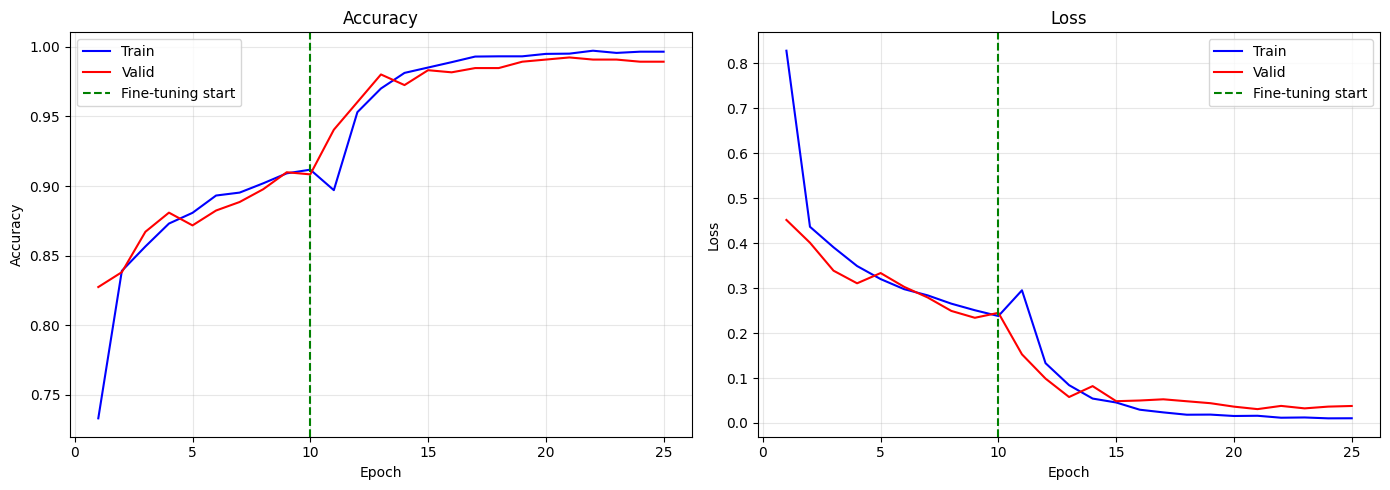

In [11]:
def plot_history(history1, history2):
    # Gom lich su
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].plot(epochs, acc, 'b-', label='Train')
    axes[0].plot(epochs, val_acc, 'r-', label='Valid')
    axes[0].axvline(x=len(history1.history['accuracy']), color='g', linestyle='--', label='Fine-tuning start')
    axes[0].set_title('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss
    axes[1].plot(epochs, loss, 'b-', label='Train')
    axes[1].plot(epochs, val_loss, 'r-', label='Valid')
    axes[1].axvline(x=len(history1.history['loss']), color='g', linestyle='--', label='Fine-tuning start')
    axes[1].set_title('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_history(history1, history2)

## 5. Evaluation

In [12]:
# Load best model
model = tf.keras.models.load_model('best_model_final.keras')

# Danh gia tren test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest Accuracy: {test_acc*100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 30s 934ms/step - accuracy: 0.9969 - loss: 0.0117

Test Accuracy: 99.85%
Test Loss: 0.0083


In [13]:
# Du doan
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = [class_names.index(label) for label in test_df['label'].values]

# Classification Report
print('Classification Report:')
print('='*60)
print(classification_report(y_true, y_pred, target_names=class_names))

21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 757ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.99      1.00       150
  meningioma       0.99      1.00      1.00       153
     notumor       1.00      1.00      1.00       203
   pituitary       1.00      1.00      1.00       150

    accuracy                           1.00       656
   macro avg       1.00      1.00      1.00       656
weighted avg       1.00      1.00      1.00       656



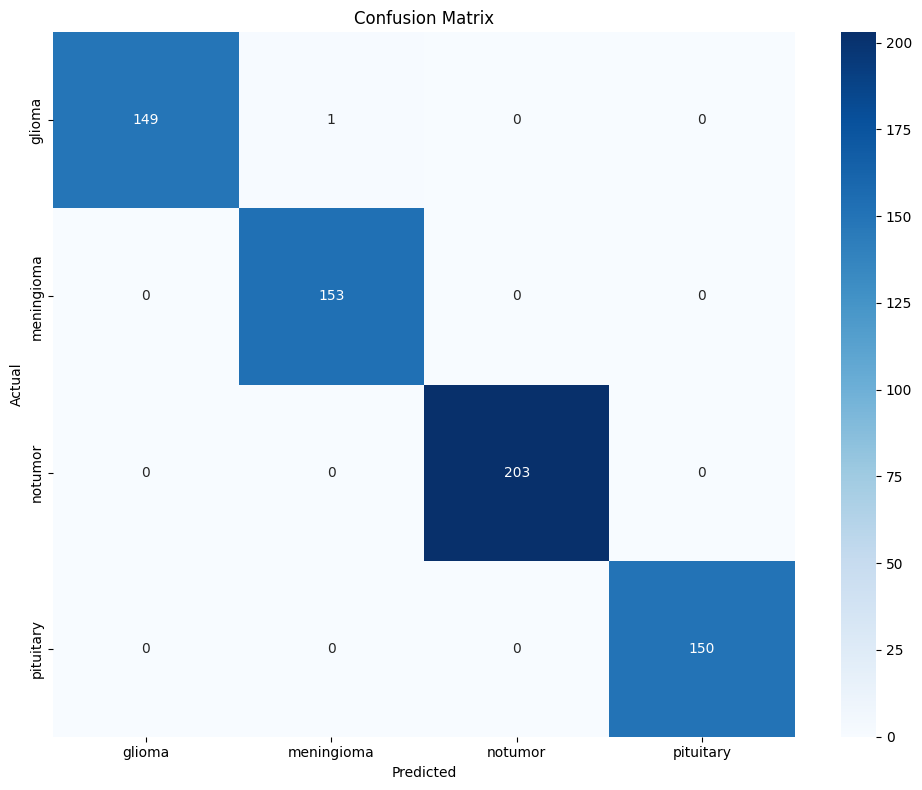

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## 6. Sample Predictions

2026-01-12 07:32:00.267835: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 07:32:00.411550: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 07:32:01.105849: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 07:32:01.238705: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 07:32:01.960410: E external/local_xla/xla/stream_

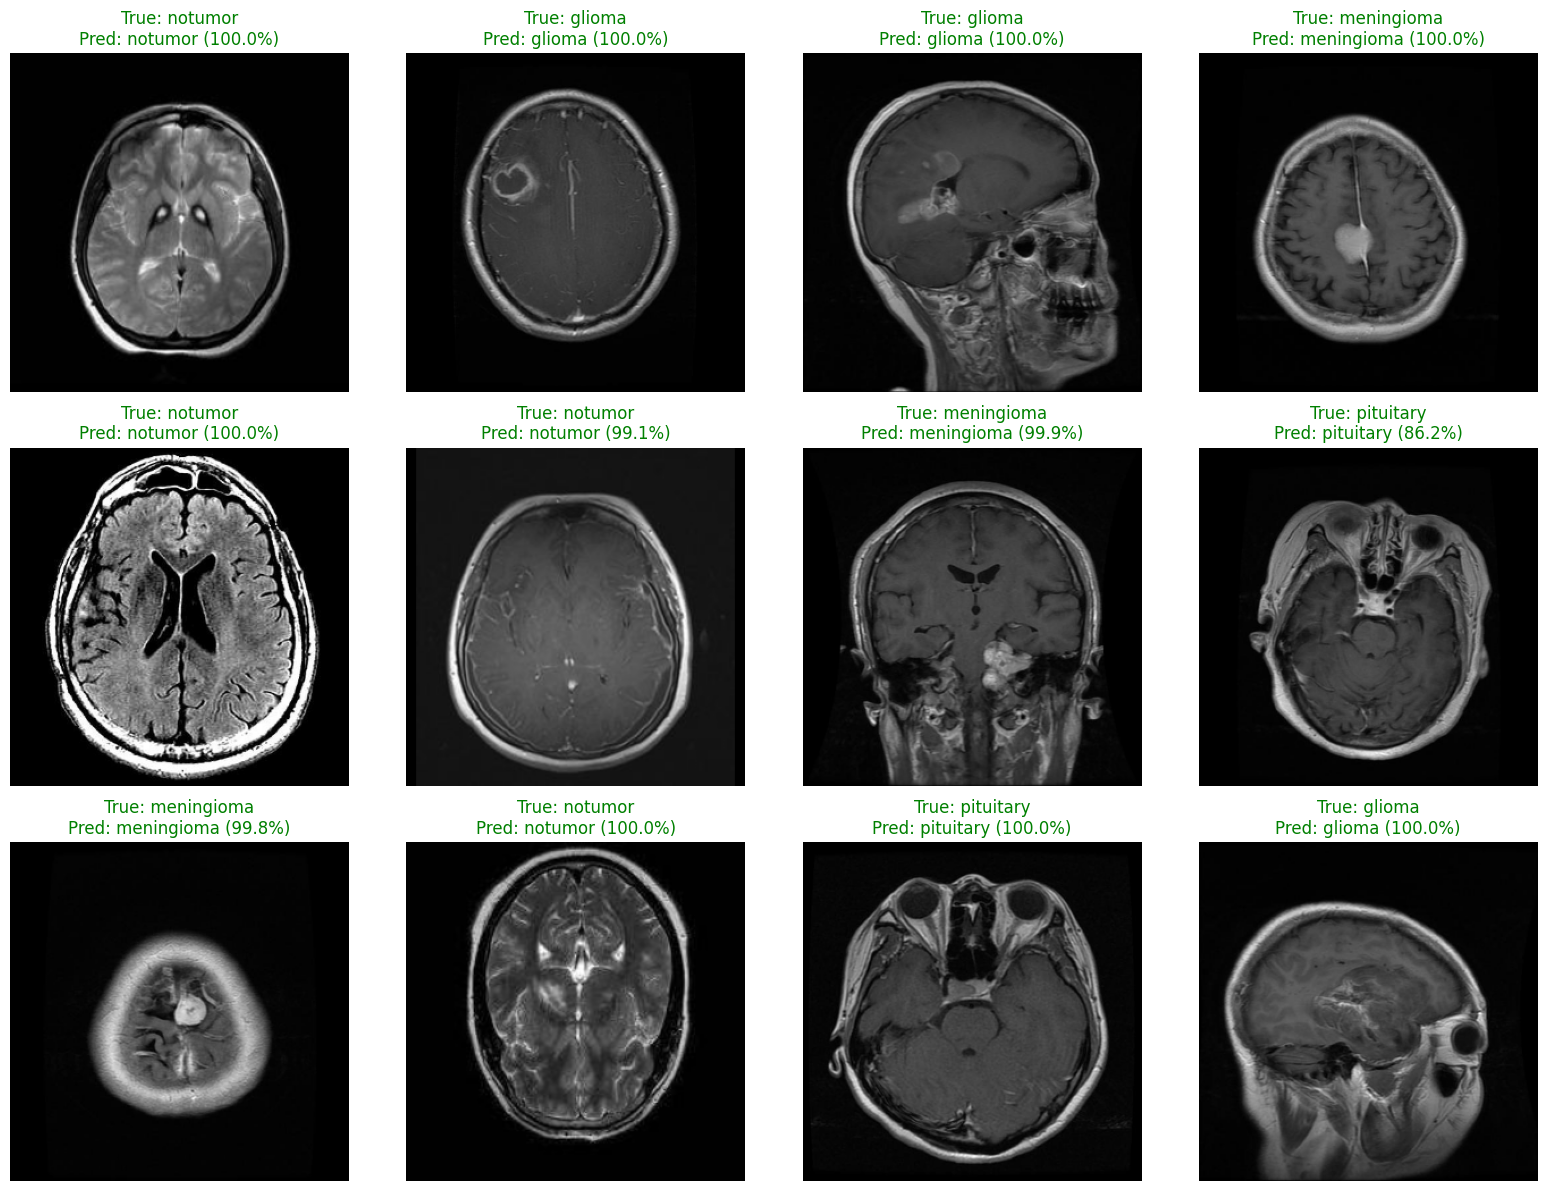

In [15]:
# Hien thi mot so du doan mau
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

# Lay mau tu test set
samples = test_df.sample(12)

for ax, (_, row) in zip(axes, samples.iterrows()):
    # Doc va xu ly anh
    img = cv2.imread(row['filepath'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_display = resize_with_padding(img, IMG_SIZE)
    img_array = preprocess_image(img_display)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Du doan
    pred = model.predict(img_array, verbose=0)
    pred_class = class_names[np.argmax(pred)]
    confidence = np.max(pred) * 100
    
    # Hien thi
    ax.imshow(img_display)
    color = 'green' if pred_class == row['label'] else 'red'
    ax.set_title(f'True: {row["label"]}\nPred: {pred_class} ({confidence:.1f}%)', color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 7. Save Model

In [16]:
# Luu model cuoi cung
model.save('brain_tumor_xception_final.keras')
print('Model saved successfully!')

Model saved successfully!


## 8. K-Fold Cross Validation

In [ ]:
# K-FOLD CROSS VALIDATION 

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("="*70)
print("K-FOLD CROSS VALIDATION (k=5) - XCEPTION")
print("="*70)


# CHUẨN BỊ DỮ LIỆU


full_train_df = pd.concat([train_df, valid_df], ignore_index=True)
print(f"\n Total samples: {len(full_train_df)}")
print(f" Classes: {sorted(full_train_df['label'].unique())}")
print(f" Class distribution:\n{full_train_df['label'].value_counts()}")

#  CẤU HÌNH 

# Phase 1 Config (Transfer Learning) 
PHASE1_EPOCHS = 10        
PHASE1_PATIENCE = 3        
PHASE1_LR = 0.001        

# Phase 2 Config (Fine-tuning) 
PHASE2_EPOCHS = 15         
PHASE2_PATIENCE = 5      
PHASE2_LR = 0.0001        

# Common Config
IMG_SIZE = (299, 299)
BATCH_SIZE = 32
N_FOLDS = 5

# Data Generators N
kfold_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

kfold_valid_datagen = ImageDataGenerator(rescale=1./255)

# HÀM TẠO MODEL 
def create_kfold_model(trainable=False, freeze_first_50=False):
    """
    Tạo Xception model
    Args:
        trainable: False cho Phase 1, True cho Phase 2
        freeze_first_50: True cho Phase 2 (freeze 50 layers đầu)
    """
    from tensorflow.keras.layers import GlobalAveragePooling2D
    
    base_model = tf.keras.applications.Xception(
        input_shape=(299, 299, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Phase 1: Freeze toàn bộ base
    # Phase 2: Unfreeze nhưng freeze 50 layers đầu
    if trainable and freeze_first_50:
        base_model.trainable = True
        for layer in base_model.layers[:50]:
            layer.trainable = False
    else:
        base_model.trainable = trainable
    
    inputs = tf.keras.Input(shape=(299, 299, 3))
    x = base_model(inputs, training=False if not trainable else True)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(4, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model


# K-FOLD CROSS VALIDATION (2 PHASES)
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

fold_results = []
fold_histories_phase1 = []
fold_histories_phase2 = []
fold_models = []

print(f"\n{'='*70}")
print(f"STARTING {N_FOLDS}-FOLD CROSS VALIDATION (2 PHASES)")
print(f"{'='*70}\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(full_train_df, full_train_df['label']), 1):
    print(f"\n{'='*70}")
    print(f"FOLD {fold}/{N_FOLDS}")
    print(f"{'='*70}")
    
    # Chia dữ liệu
    fold_train_df = full_train_df.iloc[train_idx].reset_index(drop=True)
    fold_val_df = full_train_df.iloc[val_idx].reset_index(drop=True)
    
    print(f"Train: {len(fold_train_df)} | Val: {len(fold_val_df)}")
    
    # Tạo generators
    train_gen = kfold_train_datagen.flow_from_dataframe(
        fold_train_df,
        x_col='filepath',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )
    
    val_gen = kfold_valid_datagen.flow_from_dataframe(
        fold_val_df,
        x_col='filepath',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    if fold == 1:
        class_names = list(train_gen.class_indices.keys())
        print(f"Classes: {class_names}")
    
    # PHASE 1: TRANSFER LEARNING (FROZEN BASE - 10 EPOCHS)
    
    print(f"\n{'*'*70}")
    print(f"PHASE 1: TRANSFER LEARNING (Frozen Base)")
    print(f"{'*'*70}")
    
    # Tạo model với base frozen
    fold_model = create_kfold_model(trainable=False, freeze_first_50=False)
    
    # Compile Phase 1 với lr=0.001 
    fold_model.compile(
        optimizer=Adamax(learning_rate=PHASE1_LR),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks Phase 1 
    phase1_callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=PHASE1_PATIENCE,  # 3
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,  
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    # Training Phase 1 - 10 EPOCHS
    print(f"Training Phase 1 ({PHASE1_EPOCHS} epochs)...")
    history_phase1 = fold_model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=PHASE1_EPOCHS,  # 10
        callbacks=phase1_callbacks,
        verbose=2
    )
    val_gen.reset()
    phase1_loss, phase1_acc = fold_model.evaluate(val_gen, verbose=0)
    print(f"✓ Phase 1: Loss={phase1_loss:.4f}, Acc={phase1_acc:.4f}, Epochs={len(history_phase1.history['loss'])}")
    
    # PHASE 2: FINE-TUNING (UNFREEZE, FREEZE 50 LAYERS ĐẦU - 15 EPOCHS)
    
    print(f"\n{'*'*70}")
    print(f"PHASE 2: FINE-TUNING (Unfreeze, Freeze first 50 layers)")
    print(f"{'*'*70}")
    
    # Unfreeze base nhưng freeze 50 layers đầu
    base_model = fold_model.layers[1]  # Xception layer
    base_model.trainable = True
    for layer in base_model.layers[:50]:
        layer.trainable = False
    
    # Recompile Phase 2 với lr=0.0001  
    fold_model.compile(
        optimizer=Adamax(learning_rate=PHASE2_LR),  # 0.0001
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks Phase 2 
    phase2_callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=PHASE2_PATIENCE,  # 5
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2, 
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    # Training Phase 2 - 15 EPOCHS
    print(f"Training Phase 2 ({PHASE2_EPOCHS} epochs)...")
    history_phase2 = fold_model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=PHASE2_EPOCHS,  # 15
        callbacks=phase2_callbacks,
        verbose=2
    )
    val_gen.reset()
    phase2_loss, phase2_acc = fold_model.evaluate(val_gen, verbose=0)
    print(f"Phase 2: Loss={phase2_loss:.4f}, Acc={phase2_acc:.4f}, Epochs={len(history_phase2.history['loss'])}")
    
    # Predictions
    val_gen.reset()
    y_pred = np.argmax(fold_model.predict(val_gen, verbose=0), axis=1)
    y_true = val_gen.classes
    
    # Lưu kết quả
    fold_results.append({
        'fold': fold,
        'phase1_loss': phase1_loss,
        'phase1_accuracy': phase1_acc,
        'phase2_loss': phase2_loss,
        'phase2_accuracy': phase2_acc,
        'y_true': y_true,
        'y_pred': y_pred
    })
    fold_histories_phase1.append(history_phase1)
    fold_histories_phase2.append(history_phase2)
    fold_models.append(fold_model)
    
    improvement = (phase2_acc - phase1_acc) * 100
    print(f"\n{'='*70}")
    print(f"✓ FOLD {fold} COMPLETED")
    print(f"  P1: {phase1_acc:.4f} → P2: {phase2_acc:.4f} (+{improvement:.2f}%)")
    print(f"{'='*70}")
    
    # Xóa bộ nhớ
    import gc
    tf.keras.backend.clear_session()
    gc.collect()

# KẾT QUẢ TỔNG HỢP
print(f"\n{'='*70}")
print("K-FOLD RESULTS SUMMARY")
print(f"{'='*70}\n")
avg_phase1_acc = np.mean([r['phase1_accuracy'] for r in fold_results])
std_phase1_acc = np.std([r['phase1_accuracy'] for r in fold_results])
avg_phase2_acc = np.mean([r['phase2_accuracy'] for r in fold_results])
std_phase2_acc = np.std([r['phase2_accuracy'] for r in fold_results])
print(f"Phase 1 (10 epochs): {avg_phase1_acc:.4f}(±{std_phase1_acc:.4f})")
print(f"Phase 2 (15 epochs): {avg_phase2_acc:.4f}(±{std_phase2_acc:.4f})")
print(f"Improvement: +{(avg_phase2_acc - avg_phase1_acc)*100:.2f}%")
print("\nPer-Fold:")
for r in fold_results:
    imp = (r['phase2_accuracy'] - r['phase1_accuracy']) * 100
    print(f"  Fold {r['fold']}: {r['phase1_accuracy']:.4f} → {r['phase2_accuracy']:.4f} (+{imp:.2f}%)")
#  LƯU BEST MODEL
best_fold_idx = np.argmax([r['phase2_accuracy'] for r in fold_results])
best_fold = fold_results[best_fold_idx]
best_model = fold_models[best_fold_idx]

print(f"\n{'='*70}")
print(f"BEST FOLD: {best_fold['fold']}")
print(f"P1: {best_fold['phase1_accuracy']:.4f} → P2: {best_fold['phase2_accuracy']:.4f}")
print(f"{'='*70}")

best_model.save('xception_kfold_best.h5')
print(f"\n Saved: xception_kfold_best.h5")

print(f"\n{'='*70}")
print(" K-FOLD COMPLETED!")
print(f"{'='*70}")

K-FOLD CROSS VALIDATION (k=5) - XCEPTION (2 PHASES)

 Total samples: 6367
 Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
 Class distribution:
label
notumor       1797
pituitary     1607
meningioma    1492
glioma        1471
Name: count, dtype: int64

STARTING 5-FOLD CROSS VALIDATION (2 PHASES)


FOLD 1/5
Train: 5093 | Val: 1274
Found 5093 validated image filenames belonging to 4 classes.
Found 1274 validated image filenames belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']

**********************************************************************
PHASE 1: TRANSFER LEARNING (Frozen Base)
**********************************************************************
Training Phase 1 (10 epochs)...
Epoch 1/10
160/160 - 158s - 989ms/step - accuracy: 0.7777 - loss: 0.5952 - val_accuracy: 0.8681 - val_loss: 0.3861 - learning_rate: 1.0000e-03
Epoch 2/10
160/160 - 118s - 735ms/step - accuracy: 0.8520 - loss: 0.4056 - val_accuracy: 0.8776 - val_loss: 0.3384 - le

2026-01-12 09:43:21.865153: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 09:43:22.000916: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 09:43:22.325955: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 09:43:22.464066: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 09:43:22.700163: E external/local_xla/xla/stream_

160/160 - 201s - 1s/step - accuracy: 0.9048 - loss: 0.2688 - val_accuracy: 0.9458 - val_loss: 0.1316 - learning_rate: 1.0000e-04
Epoch 2/15
160/160 - 125s - 778ms/step - accuracy: 0.9525 - loss: 0.1292 - val_accuracy: 0.9568 - val_loss: 0.1165 - learning_rate: 1.0000e-04
Epoch 3/15
160/160 - 123s - 766ms/step - accuracy: 0.9652 - loss: 0.1001 - val_accuracy: 0.9678 - val_loss: 0.0911 - learning_rate: 1.0000e-04
Epoch 4/15
160/160 - 124s - 775ms/step - accuracy: 0.9786 - loss: 0.0687 - val_accuracy: 0.9772 - val_loss: 0.0732 - learning_rate: 1.0000e-04
Epoch 5/15
160/160 - 127s - 792ms/step - accuracy: 0.9802 - loss: 0.0599 - val_accuracy: 0.9804 - val_loss: 0.0611 - learning_rate: 1.0000e-04
Epoch 6/15
160/160 - 125s - 784ms/step - accuracy: 0.9878 - loss: 0.0399 - val_accuracy: 0.9819 - val_loss: 0.0572 - learning_rate: 1.0000e-04
Epoch 7/15
160/160 - 127s - 793ms/step - accuracy: 0.9898 - loss: 0.0375 - val_accuracy: 0.9827 - val_loss: 0.0513 - learning_rate: 1.0000e-04
Epoch 8/15
16

2026-01-12 11:09:19.924990: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 11:09:20.154112: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 11:09:20.813694: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 11:09:20.986078: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 11:09:21.563940: E external/local_xla/xla/stream_

160/160 - 186s - 1s/step - accuracy: 0.7892 - loss: 0.5572 - val_accuracy: 0.8500 - val_loss: 0.4198 - learning_rate: 1.0000e-03
Epoch 2/10
160/160 - 117s - 731ms/step - accuracy: 0.8545 - loss: 0.4071 - val_accuracy: 0.8869 - val_loss: 0.3218 - learning_rate: 1.0000e-03
Epoch 3/10
160/160 - 116s - 722ms/step - accuracy: 0.8753 - loss: 0.3567 - val_accuracy: 0.8924 - val_loss: 0.3079 - learning_rate: 1.0000e-03
Epoch 4/10
160/160 - 117s - 728ms/step - accuracy: 0.8830 - loss: 0.3159 - val_accuracy: 0.8798 - val_loss: 0.3243 - learning_rate: 1.0000e-03
Epoch 5/10
160/160 - 117s - 731ms/step - accuracy: 0.9013 - loss: 0.2832 - val_accuracy: 0.9112 - val_loss: 0.2596 - learning_rate: 1.0000e-03
Epoch 6/10
160/160 - 117s - 729ms/step - accuracy: 0.9040 - loss: 0.2754 - val_accuracy: 0.8947 - val_loss: 0.2867 - learning_rate: 1.0000e-03
Epoch 7/10
160/160 - 116s - 727ms/step - accuracy: 0.9087 - loss: 0.2569 - val_accuracy: 0.9128 - val_loss: 0.2480 - learning_rate: 1.0000e-03
Epoch 8/10
16

2026-01-12 11:30:31.349188: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 11:30:31.485123: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 11:30:31.813294: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 11:30:31.951355: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 11:30:32.193827: E external/local_xla/xla/stream_

160/160 - 198s - 1s/step - accuracy: 0.9030 - loss: 0.2805 - val_accuracy: 0.9332 - val_loss: 0.1708 - learning_rate: 1.0000e-04
Epoch 2/15
160/160 - 124s - 774ms/step - accuracy: 0.9515 - loss: 0.1414 - val_accuracy: 0.9466 - val_loss: 0.1202 - learning_rate: 1.0000e-04
Epoch 3/15
160/160 - 123s - 769ms/step - accuracy: 0.9662 - loss: 0.0908 - val_accuracy: 0.9599 - val_loss: 0.1005 - learning_rate: 1.0000e-04
Epoch 4/15
160/160 - 126s - 786ms/step - accuracy: 0.9788 - loss: 0.0665 - val_accuracy: 0.9631 - val_loss: 0.0868 - learning_rate: 1.0000e-04
Epoch 5/15
160/160 - 122s - 762ms/step - accuracy: 0.9814 - loss: 0.0576 - val_accuracy: 0.9701 - val_loss: 0.0764 - learning_rate: 1.0000e-04
Epoch 6/15
160/160 - 122s - 761ms/step - accuracy: 0.9841 - loss: 0.0432 - val_accuracy: 0.9756 - val_loss: 0.0694 - learning_rate: 1.0000e-04
Epoch 7/15
160/160 - 124s - 776ms/step - accuracy: 0.9892 - loss: 0.0347 - val_accuracy: 0.9756 - val_loss: 0.0706 - learning_rate: 1.0000e-04
Epoch 8/15
16


K-FOLD RESULTS SUMMARY

Phase 1 (10 epochs): 0.9172(±0.0067)
Phase 2 (15 epochs): 0.9818(±0.0043)
Improvement: +6.46%

Per-Fold:
  Fold 1: 0.9066 → 0.9827 (+7.61%)
  Fold 2: 0.9278 → 0.9898 (+6.20%)
  Fold 3: 0.9167 → 0.9780 (+6.13%)
  Fold 4: 0.9183 → 0.9788 (+6.05%)
  Fold 5: 0.9167 → 0.9796 (+6.28%)

BEST FOLD: 2
P1: 0.9278 → P2: 0.9898

 Saved: xception_kfold_best.h5

 K-FOLD COMPLETED!


Kết quả khi chạy CV 5fold rất cao. Kết quả 2 phase chênh lệch chứng tỏ chiến lược 2 phase rất tốt

## 9. Grad-CAM Visualization

Grad-CAM (Gradient-weighted Class Activation Mapping) giúp trực quan hóa vùng ảnh mà model tập trung để đưa ra quyết định phân loại.

In [21]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Tạo Grad-CAM Model  ---
def get_grad_model(model):
    """Tạo Grad-CAM"""
    xception = [l for l in model.layers if 'xception' in l.name.lower()][0]
    conv_layer = [l for l in xception.layers if 'conv' in l.name.lower()][-1]
    grad_model = tf.keras.Model(xception.input, [conv_layer.output, xception.output])
    print(f"Grad-CAM layer: {conv_layer.name}")
    return grad_model

def generate_gradcam(model, grad_model, img_array):
    """Tạo Grad-CAM heatmap."""
    with tf.GradientTape() as tape:
        img_tensor = tf.cast(img_array, tf.float32)
        conv_out, pool_out = grad_model(img_tensor)
        tape.watch(conv_out)
        
        # Forward qua Dense layers
        x = pool_out
        for l in model.layers:
            if 'dense' in l.name or 'dropout' in l.name:
                x = l(x, training=False)
        
        # Lấy class được dự đoán
        pred_index = tf.argmax(x[0])
        loss = x[:, pred_index]
    
    grads = tape.gradient(loss, conv_out)
    
    if grads is None:
        return np.zeros((10, 10), dtype=np.float32)

    weights = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(conv_out[0] * weights, axis=-1)
    
    # ReLU + Normalize
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap)
    if max_val > 0:
        heatmap = heatmap / max_val
    
    return heatmap.numpy()

def save_gradcam_all(model, test_df, class_names, output_dir='gradcam_output'):
    """Lưu Grad-CAM cho toàn bộ tập test."""
    print("Building Grad-CAM model...")
    grad_model = get_grad_model(model)
    
    # Tạo folders
    for cls in class_names:
        os.makedirs(f'{output_dir}/{cls}', exist_ok=True)
    
    print(f'Processing {len(test_df)} images...')
    
    # Theo dõi các ảnh có vấn đề
    problem_images = []
    
    for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
        try:
            filepath = row['filepath']
            filename = os.path.basename(filepath)
            true_label = row['label']
            
            # Load ảnh gốc
            original_img = cv2.imread(filepath)
            if original_img is None:
                continue
            original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
            
            # Preprocess (giống training)
            processed_img = preprocess_image(resize_with_padding(original_img, (299, 299)))
            img_batch = processed_img[np.newaxis, ...]
            
            # DEBUG: Kiểm tra prediction
            preds = model.predict(img_batch, verbose=0)
            pred_class = class_names[np.argmax(preds[0])]
            confidence = np.max(preds[0]) * 100
            
            if pred_class != true_label or confidence < 50:
                problem_images.append({
                    'file': filename,
                    'true': true_label,
                    'pred': pred_class,
                    'conf': confidence
                })
            
            # Tạo heatmap
            heatmap = generate_gradcam(model, grad_model, img_batch)
            
            # Resize heatmap về kích thước ảnh gốc
            hm_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
            
            # Áp dụng colormap JET
            jet_heatmap = (plt.cm.jet(hm_resized)[:, :, :3] * 255).astype(np.uint8)
            
            # Overlay
            overlay = cv2.addWeighted(original_img, 0.6, jet_heatmap, 0.4, 0)
            
            # Lưu
            save_path = f"{output_dir}/{true_label}/{filename}"
            cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
            
        except Exception as e:
            print(f"Error: {filepath} - {e}")

    # In kết quả
    print(f'\n{"="*60}')
    print(f'Done! Saved to: {output_dir}/')
    for cls in class_names:
        count = len(os.listdir(f'{output_dir}/{cls}'))
        print(f'   - {cls}: {count} images')
# --- Chạy ---
save_gradcam_all(model, test_df, class_names, output_dir='gradcam_output')

Building Grad-CAM model...
Grad-CAM layer: block14_sepconv2_act
Processing 656 images...


100%|██████████| 656/656 [03:44<00:00,  2.92it/s]


Done! Saved to: gradcam_output/
   - glioma: 150 images
   - meningioma: 153 images
   - notumor: 203 images
   - pituitary: 150 images


Grad-CAM model created!


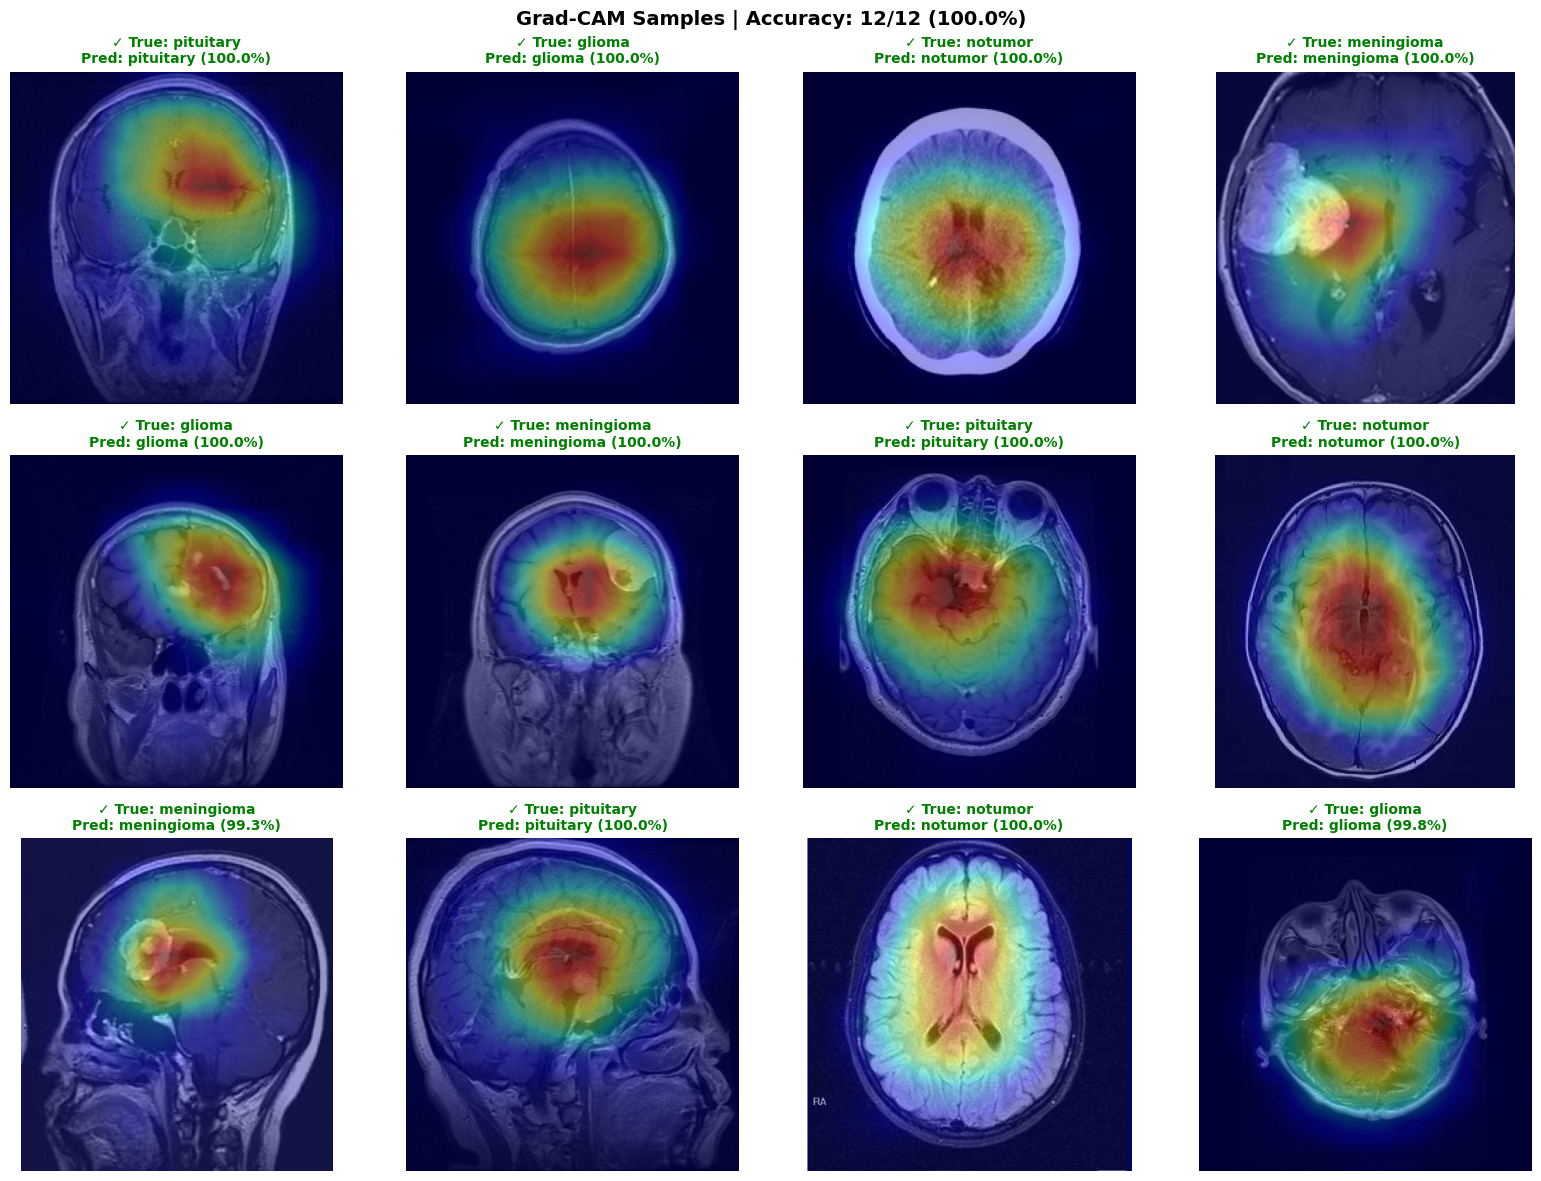


Sample Accuracy: 12/12 (100.0%)


In [22]:

# --- Tạo Grad-CAM Model ---
def get_grad_model(model):
    """Tạo Grad-CAM model một lần để tái sử dụng."""
    xception = [l for l in model.layers if 'xception' in l.name.lower()][0]
    conv_layer = [l for l in xception.layers if 'conv' in l.name.lower()][-1]
    grad_model = tf.keras.Model(xception.input, [conv_layer.output, xception.output])
    return grad_model

def generate_gradcam(model, grad_model, img_array):
    """Tạo Grad-CAM heatmap."""
    with tf.GradientTape() as tape:
        img_tensor = tf.cast(img_array, tf.float32)
        conv_out, pool_out = grad_model(img_tensor)
        tape.watch(conv_out)
        
        x = pool_out
        for l in model.layers:
            if 'dense' in l.name or 'dropout' in l.name:
                x = l(x, training=False)
        
        pred_index = tf.argmax(x[0])
        loss = x[:, pred_index]
    
    grads = tape.gradient(loss, conv_out)
    
    if grads is None:
        return np.zeros((10, 10), dtype=np.float32)

    weights = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(conv_out[0] * weights, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap)
    if max_val > 0:
        heatmap = heatmap / max_val
    
    return heatmap.numpy()

# Tạo grad_model một lần
grad_model = get_grad_model(model)
print(f"Grad-CAM model created!")

def show_gradcam_samples(model, grad_model, test_df, class_names, n_samples=12):
    """Hiển thị mẫu Grad-CAM với thông tin dự đoán."""
    samples = test_df.sample(n=n_samples, random_state=42)
    
    cols = 4
    rows = (n_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    axes = axes.flatten()
    
    correct = 0
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        # Load và xử lý
        img = cv2.cvtColor(cv2.imread(row['filepath']), cv2.COLOR_BGR2RGB)
        x = preprocess_image(resize_with_padding(img, (299, 299)))[np.newaxis, ...]
        
        # Predict
        preds = model.predict(x, verbose=0)[0]
        pred_idx = np.argmax(preds)
        pred_label = class_names[pred_idx]
        true_label = row['label']
        confidence = preds[pred_idx] * 100
        
        is_correct = pred_label == true_label
        if is_correct:
            correct += 1
        
        # Grad-CAM (SỬA: thêm grad_model)
        heatmap = generate_gradcam(model, grad_model, x)
        hm_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        jet_heatmap = (plt.cm.jet(hm_resized)[:, :, :3] * 255).astype(np.uint8)
        overlay = cv2.addWeighted(img, 0.6, jet_heatmap, 0.4, 0)
        
        # Plot
        axes[idx].imshow(overlay)
        axes[idx].axis('off')
        
        status = '✓' if is_correct else '✗'
        color = 'green' if is_correct else 'red'
        axes[idx].set_title(
            f'{status} True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
            fontsize=10, color=color, fontweight='bold'
        )
    
    # Ẩn axes thừa
    for idx in range(n_samples, len(axes)):
        axes[idx].axis('off')
    
    accuracy = correct / n_samples * 100
    plt.suptitle(f'Grad-CAM Samples | Accuracy: {correct}/{n_samples} ({accuracy:.1f}%)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    os.makedirs('gradcam_output', exist_ok=True)
    plt.savefig('gradcam_output/samples_preview.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'\nSample Accuracy: {correct}/{n_samples} ({accuracy:.1f}%)')

# Hiển thị 12 mẫu (SỬA: thêm grad_model)
show_gradcam_samples(model, grad_model, test_df, class_names, n_samples=12)